<a href="https://colab.research.google.com/github/abiyu42/toxtic_detection/blob/main/Toxic_Comments_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data source: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

### Objectives:
Build a multi-headed model capable of detecting and assigning probabilities for different types of of toxicity such as: 
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate

The dataset comprises of comments from Wikipedia's talk page (ie. discussion) pages.

## Import relevant libraries and load the data

In [19]:
# Install the nltk library in case you have not yet installed it
# pip stands for preferred installer program under Python Package Index (PyPI)

!pip install nltk

In [20]:
# Import relevant packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [21]:
# In case there is a bug, just download stopwords again.
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Stopwords are a list of 'useless' words
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Load the CSV and take a peek at 1st 5 rows

In [23]:
data=pd.read_csv('train.csv',error_bad_lines=False, engine="python")

data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 14266: unexpected end of data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14264 entries, 0 to 14263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             14264 non-null  object
 1   comment_text   14264 non-null  object
 2   toxic          14264 non-null  int64 
 3   severe_toxic   14264 non-null  int64 
 4   obscene        14264 non-null  int64 
 5   threat         14264 non-null  int64 
 6   insult         14264 non-null  int64 
 7   identity_hate  14264 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 891.6+ KB


A clean dataset with no missing values. Sweet!

## Let's see how the 1st 3 comments look like

In [25]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [26]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [27]:
data['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

The comments are dirty with '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these further down the pipeline.

## Exploratory Data Analysis

In [28]:
# Check percentage of comments that are toxic compared to normal comments
data.toxic.value_counts(normalize=True)

0    0.90774
1    0.09226
Name: toxic, dtype: float64

Cool. It seems that 90% of the comments fall in the toxic category.

In [29]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [30]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()

In [31]:
data_count

toxic            1316
severe_toxic      142
obscene           727
threat             44
insult            677
identity_hate     128
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


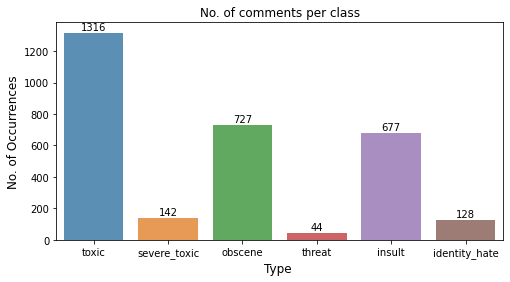

In [32]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [33]:
num_rows = len(data)
print(num_rows)

14264


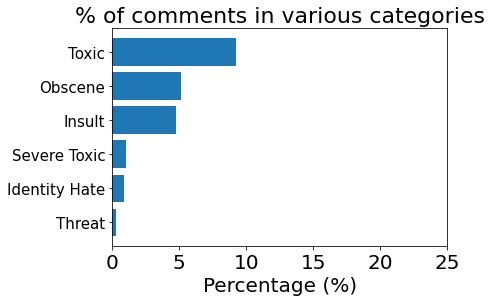

In [34]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Preprocess the text

In [35]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

## Separate our dataset into 6 sections. Each section is comment + 1 category.

In [36]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [37]:
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [38]:
data_tox['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [39]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [40]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [41]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [42]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [43]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

## Creating WordCloud
### Useful to show the words which occur most frequently for each category. Warning: Profanity ahead.

In [44]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [45]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

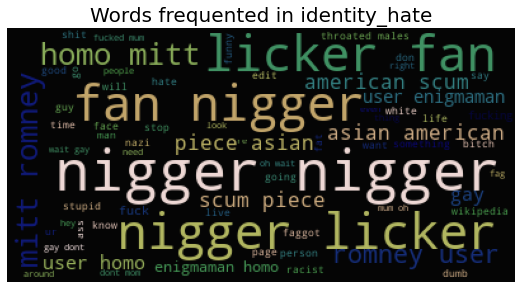

In [46]:
wordcloud(data_ide,'identity_hate')

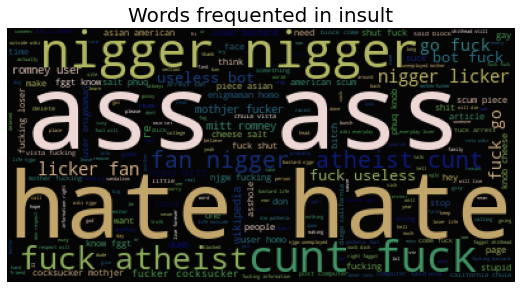

In [47]:
wordcloud(data_ins, 'insult')

#### Earlier, we saw that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data. This leads to the issue of class imbalance.

#### We can deal with class imbalance by taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

#### For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [48]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [49]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(1316, 3)

In [50]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [51]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(6316, 3)

### Not all categories have 5000 rows. So we should count them first and make them balanced.

In [52]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              142
comment_text    142
severe_toxic    142
dtype: int64

In [53]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(1737, 3)

Cool. We only had 1,595 comments that are severely toxic. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [54]:
data_obs[data_obs['obscene'] == 1].count()

id              727
comment_text    727
obscene         727
dtype: int64

In [55]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(5727, 3)

In [56]:
data_thr[data_thr['threat'] == 1].count()

id              44
comment_text    44
threat          44
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [57]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(1956, 3)

In [58]:
data_ins[data_ins['insult'] == 1].count()

id              677
comment_text    677
insult          677
dtype: int64

In [59]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(5677, 3)

In [60]:
data_ide[data_ide['identity_hate'] == 1].count()

id               128
comment_text     128
identity_hate    128
dtype: int64

In [61]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(5748, 3)

Reminder: Number of comments that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df_****_done refers to the dataframes of each class that has been balanced (at least 20/80 proportion)

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [62]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


### Create simple function that takes in a dataset and allows user to choose dataset, toxicity label, vectorizer and number of ngrams

In [63]:
'''
df_done: data_tox_done, data_sev_done, ...
label: toxic, severe_toxic, ...
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [64]:
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram)
vectorizer values: CountVectorizer, TfidfVectorizer
ngram_range values: (1,1) for unigram, (2,2) for bigram
'''

import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

# Various permutations of the dataset, category, vectorizer and n-gram

# cv_tf_train_test(data_tox_done, 'toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', CountVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', CountVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', CountVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', CountVectorizer, (1,1))

# cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))


lr done
bnb done
mnb done
rdf done
Time taken: 4.782371282577515 seconds


,F1 Score(toxic)
Log Regression,0.542314
KNN,0.681122
BernoulliNB,0.432030
MultinomialNB,0.397706
SVM,0.800546
Random Forest,0.757979


In [65]:

t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
bnb done
mnb done
rdf done
Time taken: 0.7540481090545654 seconds


,F1 Score(severe_toxic)
Log Regression,0.360000
KNN,0.520833
BernoulliNB,0.050000
MultinomialNB,0.205128
SVM,0.567164
Random Forest,0.481928


In [66]:

t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

lr done
bnb done
mnb done
rdf done
Time taken: 3.044220209121704 seconds


,F1 Score(obscene)
Log Regression,0.541667
KNN,0.539130
BernoulliNB,0.129278
MultinomialNB,0.311419
SVM,0.797136
Random Forest,0.826291


In [67]:

t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
bnb done
mnb done
rdf done
Time taken: 0.651085376739502 seconds


,F1 Score(threat)
Log Regression,0.000000
KNN,0.000000
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.461538
Random Forest,0.444444


In [68]:

t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

lr done
bnb done
mnb done
rdf done
Time taken: 3.358471632003784 seconds


,F1 Score(insult)
Log Regression,0.450980
KNN,0.144578
BernoulliNB,0.097959
MultinomialNB,0.229885
SVM,0.680412
Random Forest,0.698163


In [69]:

t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

lr done
bnb done
mnb done
rdf done
Time taken: 2.2907958030700684 seconds


,F1 Score(identity_hate)
Log Regression,0.081633
KNN,0.285714
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.437500
Random Forest,0.379310


In [70]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.542314,0.360000,0.541667,0.450980,0.000000,0.081633
KNN,0.681122,0.520833,0.539130,0.144578,0.000000,0.285714
BernoulliNB,0.432030,0.050000,0.129278,0.097959,0.000000,0.000000
MultinomialNB,0.397706,0.205128,0.311419,0.229885,0.000000,0.000000
SVM,0.800546,0.567164,0.797136,0.680412,0.461538,0.437500
Random Forest,0.757979,0.481928,0.826291,0.698163,0.444444,0.379310


### Transpose the combined F1 dataframe to make it suitable for presentation on a graph

In [71]:
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.542314,0.681122,0.432030,0.397706,0.800546,0.757979
F1 Score(severe_toxic),0.360000,0.520833,0.050000,0.205128,0.567164,0.481928
F1 Score(obscene),0.541667,0.539130,0.129278,0.311419,0.797136,0.826291
F1 Score(insult),0.450980,0.144578,0.097959,0.229885,0.680412,0.698163
F1 Score(threat),0.000000,0.000000,0.000000,0.000000,0.461538,0.444444
F1 Score(identity_hate),0.081633,0.285714,0.000000,0.000000,0.437500,0.379310


In [72]:
sns.lineplot(data=f1_all_trp, size=[10,10], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

# Repeat this for CountVectorizer as well

ValueError: ignored

LinearSVC and Random Forest models perform best (purple and brown lines seem to be the highest).

### Test if our code actually works. Probability of the comment falling in various categories should be output.

In [ ]:
data_tox_done.head()

In [ ]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)



In [ ]:
# Sample Prediction
comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

In [ ]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

Random forest has assigned a probability of 1 that comment 1 ('you piece of shit') is toxic. Comment 2 has only a low toxicity probability of 0.16.

## Pickling trained RandomForest models for all categories. 

#### We choose Random Forest instead of LinearSVC although the latter performs well, as RDF has predict_proba function and LinearSVC does not. We need to output a probability score for each comment, remember?

In [ ]:
import pickle

### We have to pickle not only the TF-IDF vectorizer object, but also the RDF model trained on the related vectorizer.

In [ ]:
'''
NOTE: This step has already been done for you. The pickled files are included in the github. Just for further reference.
You do NOT have to run this cell.
'''

def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    # saves the column labels (ie. the vocabulary)
    # wb means Writing to the file in Binary mode, written in byte objects
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    # Create a new pickle file based on random forest
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(randomforest, f)
        

### Create a loop to create pickle files all at one shot

In [ ]:
'''
OPTIONAL STEP. Pickled file already available on Github.

datalist = [data_tox_done, data_sev_done, data_obs_done, data_ins_done, data_thr_done, data_ide_done]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)
    
'''